## Importing Libraries
Let's first start with importing the necessary modules. The model architecture along with some helper functions can be found in the 'scripts' directory.

In [44]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from scripts.heatmap import heatmap, annotate_heatmap
from scripts.iqr import find_outliers_IQR
from scripts.models import *


This study aims to predict weekly load demand in nine different regions of Bangladesh simultaneously. These regions are **'Dhaka'**, **'Chittagong'**, **'Comilla'**, **'Mymensingh'**, **'Sylhet'**, **'Khulna'**, **'Rajshahi'**, **'Barishal'**, and **'Rangpur'**. Let's first define the root, dataset and model path directories.

In [30]:
root_dir = ''
dataset_path = os.path.join(root_dir, 'dataset')
model_path = os.path.join(root_dir, "Trained Models")

regions = ['dhaka', 'chittagong', 'comilla', 'mymensingh',
       'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']

## Loading Dataset

The dataset for the work is located in the **dataset** directory. The 'zone_demand.xlsx' file contains the real world historical electrical demands extracted from the 'Power Grid Company of Bangladesh' website. The reported date is one day later than the actual date of the demand. Thus we need to shift the dates 1 day in the future. Moreover this initial dataset contains a lot of duplicate and missing values. So, we need to fix them first. The missing dates can be repopulated by utilizing time-interpolatation, an amazing mathematical tool. 

In [8]:
#Loading Load Demand Dataset

demand_data_path = 'dataset/zone_demand.xlsx'
df = pd.read_excel(os.path.join(root_dir, demand_data_path))

#Reversing historical dataset into ascending order
df = df.iloc[::-1]
df.reset_index(drop=True, inplace = True)

# Since the actual demand is reported one day later, we need to shift the date by 1 day behind
df["date"] = df["date"] + pd.Timedelta(days=1)


In [9]:
# checking the missing dates

missing_days = pd.date_range(start = '2014-01-01', end = '2022-12-20' ).difference(df['date'].dt.date)
n_missing_days = len(missing_days)
print(f'Number of missing days in the dataset : {n_missing_days} \n\nThe missing Dates {missing_days}')

Number of missing days in the dataset : 115 

The missing Dates DatetimeIndex(['2014-02-11', '2014-02-26', '2014-03-12', '2014-03-22',
               '2014-03-23', '2014-04-03', '2014-04-04', '2014-04-05',
               '2014-04-11', '2014-04-12',
               ...
               '2021-06-05', '2021-06-11', '2021-08-31', '2021-09-30',
               '2021-10-02', '2021-11-16', '2022-01-04', '2022-06-14',
               '2022-09-04', '2022-11-23'],
              dtype='datetime64[ns]', length=115, freq=None)


In [11]:
## Fixing the missing values
df.set_index('date',inplace=True)
df.index = pd.DatetimeIndex(df.index.date)
df.dropna(axis=0, inplace= True)

Note: Some dates (About 40-50) were mistakenly placed. We had to manually fix those dates. The mistakenly placed dates were easily found by setting the date columns as index and running the below cell. 

In [29]:
# Check duplicate dates manually using the code below and fix them manually in the excel file 
#df[df.index.duplicated()]

In [12]:
# Once there are no duplicate entries, we can fill the missing days

# creating a date range from start to end period and reindex dataframe
idx= pd.date_range(start = '2014-01-01', end = '2022-12-20' )
df = df.reindex(idx)
print(df.shape)

(3276, 9)


In [13]:
# Interpolation to fill the missing days
df.interpolate(method= 'time', inplace = True)
df.reset_index(inplace = True)
df.rename(columns = {'index':'dates'}, inplace = True)

# Adding month column
df["month"] = pd.Series([i.month for i in df.dates])

In [15]:
# Saving the Initially Preprocessed File
demand_data_path2 = 'dataset/demand_data.csv'

#df.to_csv(os.path.join(root_dir, demand_data_path2), index= False)
df = pd.read_csv(os.path.join(root_dir, demand_data_path2))

## Outlier Removal
The dataset at this point contains a lot of outliers. Outliers are natural for real-world power system data. As the nature of load demand and supply depends on a lot of unsudden factors in a demographic regions (Such as, natural disasters, weather, power plant failure, public events to name a few). However this is bad from the perspective of a Machine Learning Model. Thus we need to remove these outliers as much as possible.

There are many outlier removal mechanisms (Such as, applying moving average, KNN, IQR etc.). As the dataset is non stationary, we first divide the whole dataset into ***K*** equal sections so that it approximately shows stationary behavior. Then we applied IQR method on each sections. After detecting the outlier values, we fix them by averaging the values from two weeks into the past and future together. 

In [16]:
# Outlier Removal
df_wOutliers = df.copy()

# indexes at split points
k = 50
split = int(df.shape[0]/k)
idxs = [x*split for x in range(k+1)]
print(f'The dataset will be evenly split at the following indexes \n {idxs}')

The dataset will be evenly split at the following indexes 
 [0, 65, 130, 195, 260, 325, 390, 455, 520, 585, 650, 715, 780, 845, 910, 975, 1040, 1105, 1170, 1235, 1300, 1365, 1430, 1495, 1560, 1625, 1690, 1755, 1820, 1885, 1950, 2015, 2080, 2145, 2210, 2275, 2340, 2405, 2470, 2535, 2600, 2665, 2730, 2795, 2860, 2925, 2990, 3055, 3120, 3185, 3250]


In [18]:
outliers_index = {}

for region in regions:
  outliers_in_region = []
  for i in range(k):
    indices, min, max = find_outliers_IQR(df[region][idxs[i]:idxs[i+1]])
    for j in indices:
      outliers_in_region.append(j)
  
  outliers_index[region] = outliers_in_region


# Number of Outliers in
for region in outliers_index:
    print(f'The number of outlier values in {region}: {len(outliers_index[region])}')

The number of outlier values in dhaka: 172
The number of outlier values in chittagong: 126
The number of outlier values in comilla: 128
The number of outlier values in mymensingh: 151
The number of outlier values in sylhet: 134
The number of outlier values in khulna: 161
The number of outlier values in rajshahi: 151
The number of outlier values in barishal: 144
The number of outlier values in rangpur: 87


The graph below shows one of ***k*** sections. As you can observe, the outlier values are effectively cutout by the two Red lines. Later, another graph, compares between the dataset with outliers and without outliers (Using our method). 

Detecting outliers in khulna for values between 2014-05-11 00:00:00 and 2014-07-15 00:00:00


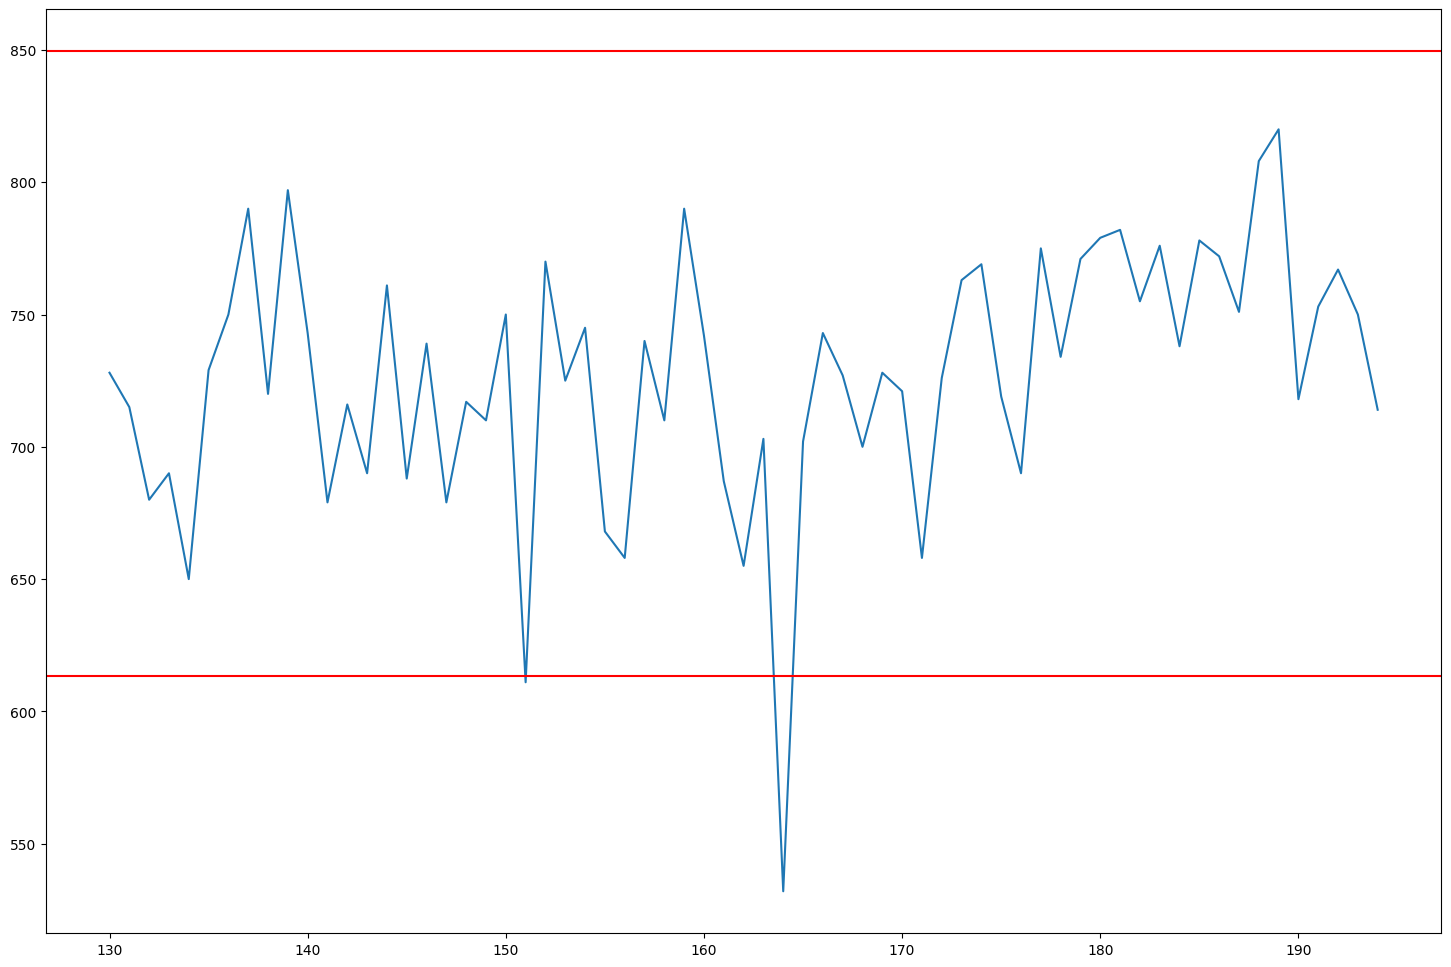

In [19]:
# To Plot data for a certain split value and area
def plot_outlier(area, k_idx):
    _, min, max = find_outliers_IQR(df[area][idxs[k_idx]:idxs[k_idx+1]])
    df[area][idxs[k_idx]:idxs[k_idx+1]].plot(figsize = [18,12])
    plt.axhline(y=min, color='r', linestyle='-')
    plt.axhline(y=max, color='r', linestyle='-')

region = 'khulna'
k_idx = 2

plot_outlier(region, k_idx)
print(f'Detecting outliers in {region} for values between {df.loc[idxs[k_idx]].dates} and {df.loc[idxs[k_idx+1]].dates}')

In [20]:
# Fixing The Outliers

# Weeks to see in the future and past for averaging
weeks = 2

for region in regions:
  for i in outliers_index[region]:
    avg = []
    prev_value = df.loc[i,region] 

    # past weeks
    for j in range(weeks):
      if (i-(j+1)*7) >= 0 and df.loc[i-(j+1)*7,region]:
        avg.append(df.loc[i-(j+1)*7,region])

    # future weeks
    for j in range(weeks):
      if (i+(j+1)*7) <= df.shape[0] and df.loc[i+(j+1)*7, region]:
        avg.append(df.loc[i+(j+1)*7, region])
  
    new_value = sum(avg)/len(avg)
    df.loc[i, region] = new_value

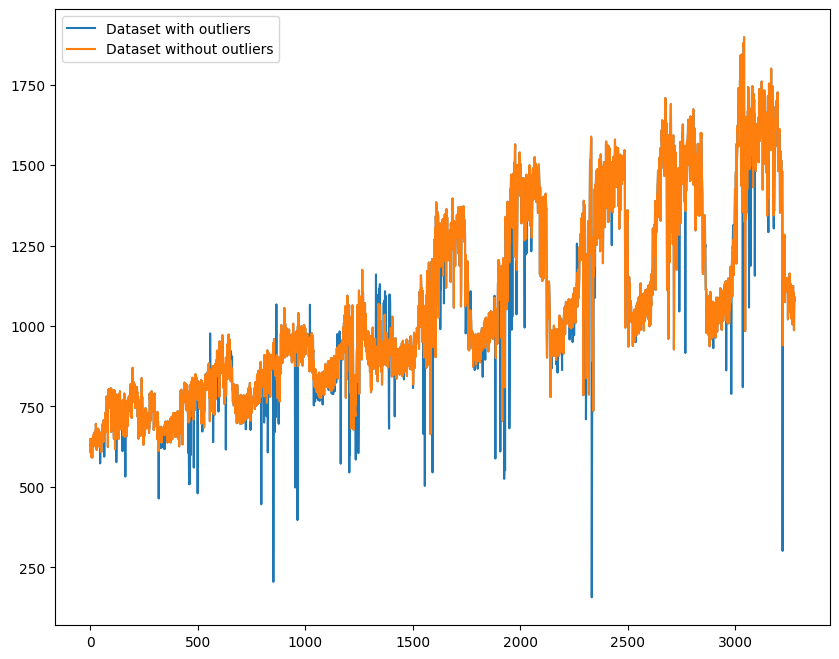

In [21]:
# To illustrate plotting a particular region before and after fixing outliers
region = 'khulna'
df_wOutliers[region].plot(figsize = [10,8], label = 'Dataset with outliers')
df[region].plot(figsize = [10,8], label = 'Dataset without outliers')
plt.legend()

In [22]:
# Saving the dataset without outliers
filepath = os.path.join(root_dir,'dataset/demand_wo_outliers.csv')
#df.to_csv(filepath, index = False)
df = pd.read_csv(filepath)

## Feature Selection
Now we need to take some major decisions. To train a sequence learning models we need two important things. First, the appropriate feature parameters and second the appropriate lookback, in other words the length of the sequence that are going to be passed into the model. To determine these things we, use pearson correlation. The correlation matrix between different regions and the correlation matrix between different timesteps are calculated in the subsequent figures. Since our aim is to predict weekly load demand, it is enough for our model to look into 20 days into the past as you shall see.

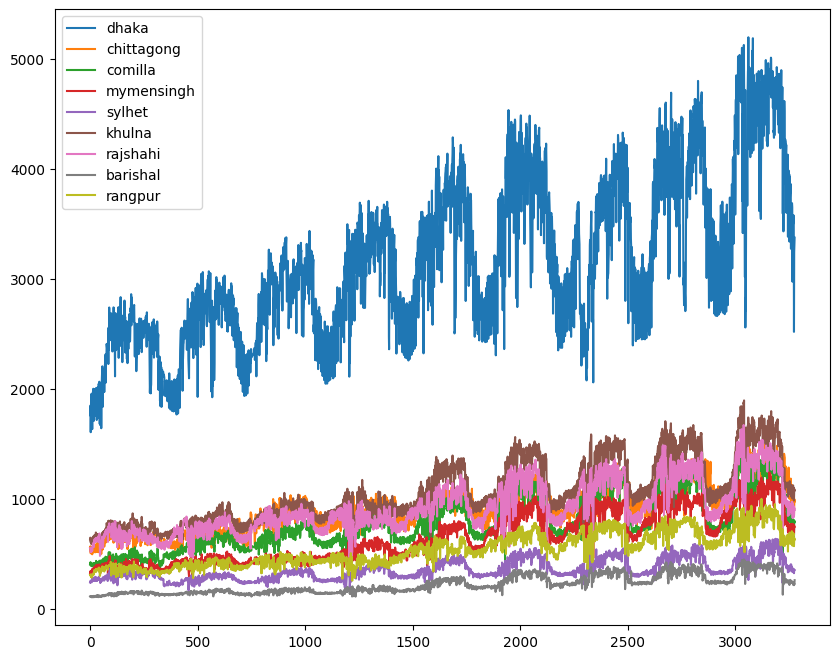

In [23]:
# Plotting load demand of different regions

plt.figure(figsize = (10,8))
plt.plot(df[regions], label = regions)
plt.legend()
plt.savefig(os.path.join(root_dir,'figures/zone_demand.png'), dpi = 500)
plt.show()

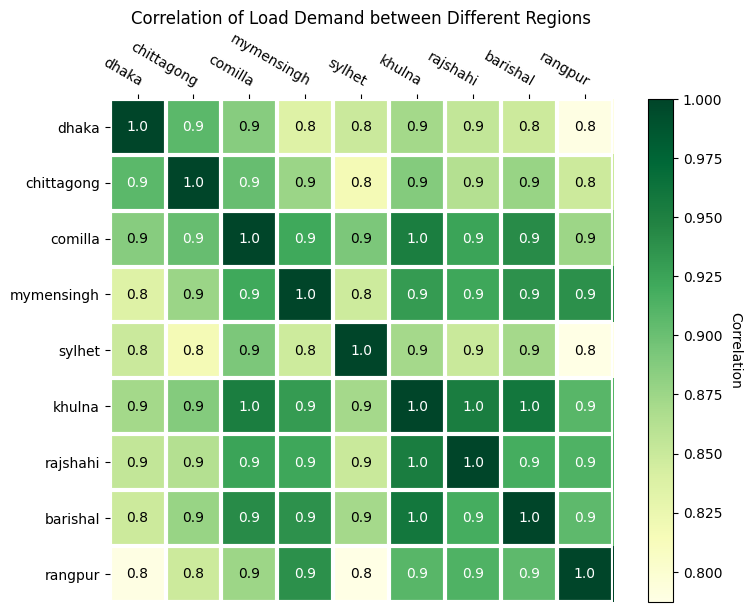

In [24]:
# Calculating Correlation among different parameters

matrix = df[regions].corr()

fig, ax = plt.subplots(figsize = (8,6))

im, cbar = heatmap(data = matrix, row_labels = regions, col_labels = regions, ax=ax,cmap="YlGn", cbarlabel="Correlation")
texts = annotate_heatmap(im, valfmt="{x:.1f}")
fig.tight_layout()
plt.savefig(os.path.join(root_dir, 'figures/corr_all_division.png'), dpi = 500)
plt.title('Correlation of Load Demand between Different Regions')
plt.show()

In [25]:
def calc_correlation_timelags(data, region, lookback = 40, interval=5):
    data = data.copy()
    for i in range(interval, lookback+1, interval):
        data[region+f'_{i}'] = pd.Series(data[region][i:].values)
    
    matrix = data[:-lookback].corr()
    
    fig, ax = plt.subplots(figsize = (10,8))
    im, cbar = heatmap(matrix, data.columns, data.columns, ax=ax, cmap="YlGn", cbarlabel="Correlation Matrix")
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    fig.tight_layout()
    plt.title(f'Correlation among different timelags for {region} region with {interval} interval')
    plt.savefig(os.path.join(root_dir, 'figures/corr_chittagong.png'), dpi = 500)
    plt.show()

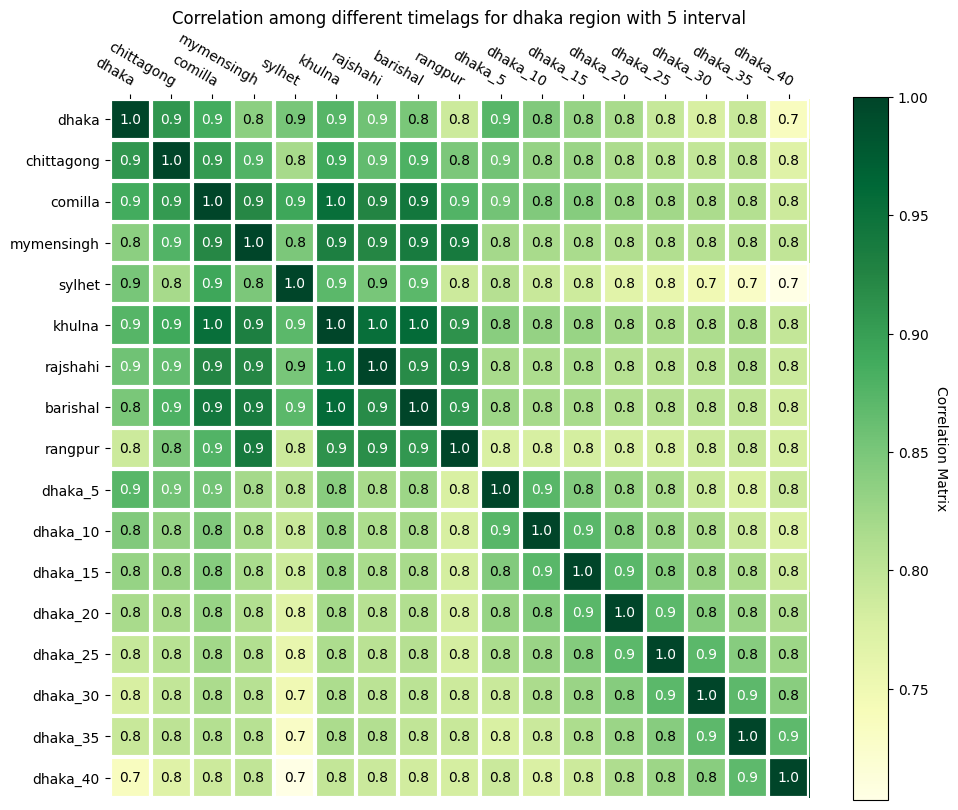

In [26]:
# Calculating Correlation among different time lags

calc_correlation_timelags(data = df[regions], region = 'dhaka')

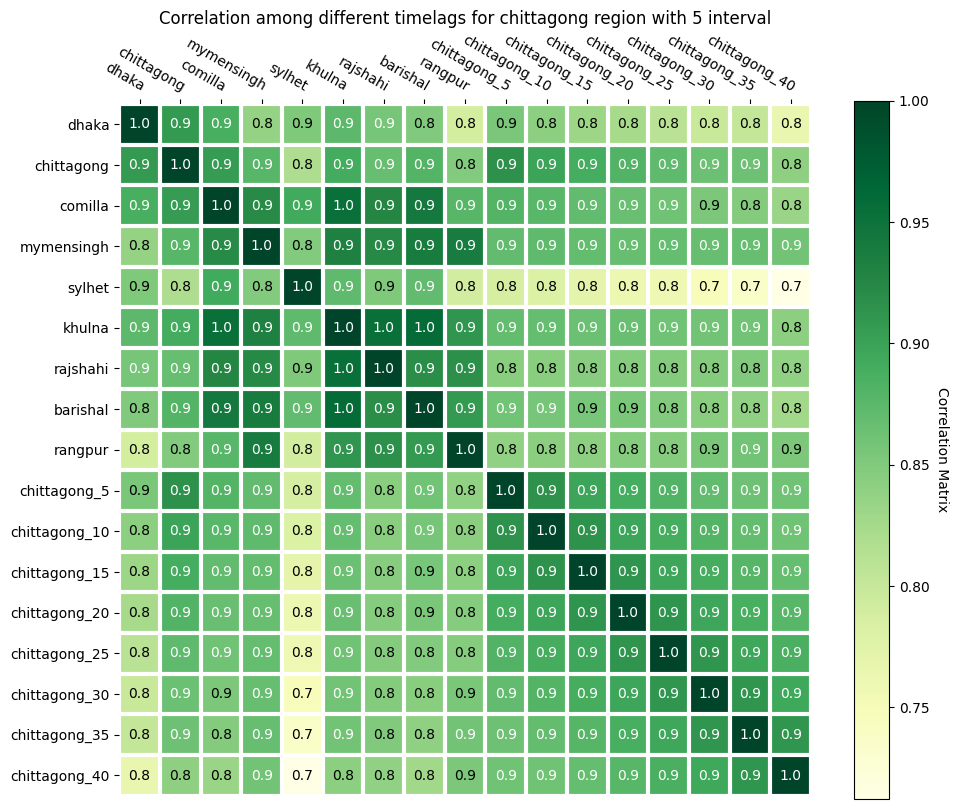

In [27]:
# Calculating Correlation among different time lags

calc_correlation_timelags(data = df[regions], region = 'chittagong')

In [28]:
# Selecting Features
features = regions.copy()
features.insert(0, 'month')

print('Number of Features: {}'.format(len(features)))
print('Featured selected: {}'.format(features))

Number of Features: 10
Featured selected: ['month', 'dhaka', 'chittagong', 'comilla', 'mymensingh', 'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']


## Further Interpolation
This step is optional because this seems to extend the accuracy of our model a little. For accurate time series forecasting, having data of smaller intervals and quality is crucial. Our initial data is daily. In this step we make our data daily by interpolating 24 measurements inside beween days.

In [29]:
# Extending the dataset by interpolation
df.set_index('dates', inplace = True) # Setting index to dates
df.index = pd.to_datetime(df.index)

# Creating hourly time index
interpolated_df = pd.DataFrame(columns = regions)
interpolated_df['dates'] = pd.date_range(start ='2014-01-01 00:00:00', end = '2022-12-20 23:00:00', freq = 'H')
interpolated_df.set_index('dates', inplace = True)

# putting the values of original dataframe to the new one at the the apropriate datetime
for i in df.index:
  for region in regions:
    interpolated_df.loc[i, region] = df.loc[i, region]

# interpolating 
interpolated_df = interpolated_df[regions].astype('float')
interpolated_df = interpolated_df.interpolate(method='time', axis = 'index')
interpolated_df['month'] = interpolated_df.index.month

#reseting index
interpolated_df.reset_index(inplace = True)
df.reset_index(inplace = True)


print(f'Interpolated dataframe shape = {interpolated_df.shape}')
print(interpolated_df.head())

Interpolated dataframe shape = (78624, 11)
                dates        dhaka  chittagong  comilla  mymensingh  \
0 2014-01-01 00:00:00  1763.000000  565.000000  407.000  327.000000   
1 2014-01-01 01:00:00  1764.291667  563.541667  407.375  327.666667   
2 2014-01-01 02:00:00  1765.583333  562.083333  407.750  328.333333   
3 2014-01-01 03:00:00  1766.875000  560.625000  408.125  329.000000   
4 2014-01-01 04:00:00  1768.166667  559.166667  408.500  329.666667   

       sylhet      khulna  rajshahi  barishal     rangpur  month  
0  243.000000  635.000000   555.000   115.000  312.000000      1  
1  243.333333  635.583333   554.875   114.875  311.791667      1  
2  243.666667  636.166667   554.750   114.750  311.583333      1  
3  244.000000  636.750000   554.625   114.625  311.375000      1  
4  244.333333  637.333333   554.500   114.500  311.166667      1  


In [ ]:
# Saving the interpolated dataset

#df.to_excel(dataset_path+'/interpolated_data.xlsx', index = False)
df = pd.read_csv(dataset_path+'/interpolated_data.xlsx')

To feed our AI model, we need to convert our dataset into appropriate shape. The dataset is first converted into a numpy array and scaled down between 0 and 1. Scaling the data using mean and standard deviation is also an option. However we have found that normalizing between 0 and 1 produced the best result. Scaling is done to ensure all parameters are in the same scale (helpful for model training).

After normalizing the dateset will be prepared into sequence to feed our models. So, for each seven days demand into the future, we make the sequence of past 20 days demand data as input. This lookback window is determined after examining the correlation matrix above. Subsequently, we split the dataset into train, test and validation.

In [31]:
# Converting Dataframe to Numpy array for model training

training_set = interpolated_df[features].astype(float).to_numpy()
print('Training set shape == {}'.format(training_set.shape))
print('All timestamps == {}'.format(len(interpolated_df['dates'].values)))


Training set shape == (78624, 10)
All timestamps == 78624


In [32]:
# Scaling Data
mm = MinMaxScaler((0,1))
mm = mm.fit(training_set)
scaled_train = mm.transform(training_set)

# minMaxScalar for prediction 
mm_predict = MinMaxScaler((0,1))
mm_predict = mm_predict.fit(training_set[:,1:10])

In [33]:
# However, We test on Original Data, not on the interpolated one.
# Thus we set aside six months worth of data from the original set for testing

test_set = df[features].iloc[-200:].astype(float).to_numpy()

scaled_test = mm.transform(test_set)
scaled_train = scaled_train[:-200*24]

In [34]:
# Preparing time sequence for Test Data

# Time Sequence Parameters

n_future = 7
n_past = 20
step = 1

x_test = []
y_test = []

for i in range(n_past, len(scaled_test) - n_future +1):
    x_test.append(scaled_test[i - n_past:i:step, 0: scaled_test.shape[-1]])
    y_test.append(scaled_test[i + n_future - 1,1:10])

x_test, y_test = np.array(x_test), np.array(y_test)

print('x_test shape == {}.'.format(x_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

x_test shape == (174, 20, 10).
y_test shape == (174, 9).


In [35]:
# Preparing TimeSequence for train data

## Time sequence parameters if we interpolated the data
n_future = 7*24     # Number of days we want top predict into the future 
n_past = 20*24      # Number of past days we want to use to predict the future
step = 1*24           # Step size default  1


x_train = []
y_train = []

for i in range(n_past, len(scaled_train) - n_future +1):
    x_train.append(scaled_train[i - n_past:i:step, 0: scaled_train.shape[-1]])
    y_train.append(scaled_train[i + n_future - 1,1:10])

    
x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

x_train shape == (73177, 20, 10).
y_train shape == (73177, 9).


In [36]:
# Spliting the training data into train (90%) and validation set (10%)

train_val_split = int(len(x_train)*0.9)
x_val = x_train[train_val_split:]
y_val = y_train[train_val_split:]

x_train = x_train[:train_val_split]
y_train = y_train[:train_val_split]

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

print('x_val shape == {}.'.format(x_val.shape))
print('y_val shape == {}.'.format(y_val.shape))


x_train shape == (65859, 20, 10).
y_train shape == (65859, 9).
x_val shape == (7318, 20, 10).
y_val shape == (7318, 9).


# Model Training

Finally, after hectic work of data preprocessing we can dive into the interesting part! 'MODEL TRAINING'. In this study, we have experimented with Transformers, Convolutional Neural Network (CNN), Long Short Term Memory (LSTM), Gated Recurrent Unit (GRU) and their combinations. CNN is an excellent feature extractors. We have found that, the CNN-GRU model outperforms the other models even beating the Transformer models.

The model architectures can be found the scripts folder. The trained models components are stored in the directory named 'Trained Models'.

In [58]:
# Defining Model 

input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'CNN_GRU'

print(f'Loading {model_name} Model')

if model_name == 'Transformer':

    model = build_transformer_model(
        input_shape,
        head_size=3,
        n_heads=3,
        fcl_dim=32, 
        n_transformer=2,
        dropout=0.1,
    )

elif model_name == 'Transformer_LSTM':
    
    model = build_transformer_lstm_model(
    input_shape,
    head_size=3,
    n_heads=3, 
    fcl_dim=32, 
    n_transformer=1,
    dropout=0.1,
    )

elif model_name == 'CNN_Transformer':

    model = build_cnn_transformer_model(
        input_shape,
        head_size=16,
        n_heads=4, 
        fcl_dim=32, 
        n_transformer=1,
        dropout=0.1,
    )

elif model_name == 'LSTM':

    model = build_lstm_model(
        input_shape,
        mlp_dropout=0.2,
        dropout=0.2,
    )

elif model_name == "CNN_LSTM":
    model = build_cnn_lstm_model(
        input_shape,
        mlp_dropout=0.1,
        dropout=0.1,
    )

elif model_name == "GRU":
    model = build_gru_model(
        input_shape,
        mlp_dropout=0.1,
        dropout=0.1,
    )

else:
    model = build_cnn_gru_model(
        input_shape,
        mlp_dropout=0.1,
        dropout=0.1,
    )

model.compile(
    loss=['mse' for i in range(len(regions))],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5) 
)

print(model.summary())
keras.utils.plot_model(model)

Loading CNN_GRU Model
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 18, 128)      3968        ['input_8[0][0]']                
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 9, 128)      0           ['conv1d_7[0][0]']               
                                                                                                  
 gru_7 (GRU)                    (None, 64)           37248       ['max_pooling1d_7[0][0]']        
                                                                      

In [59]:
# Model Training

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]


history= model.fit(
    x_train,
    [i for i in y_train.T],
    shuffle = True,
    validation_data = (x_val,[k for k in y_val.T]),
    epochs= 50,
    callbacks= callbacks
    )

Epoch 1/50
2059/2059 [==============================] - 35s 15ms/step - loss: 0.3402 - dhaka_loss: 0.0605 - chittagong_loss: 0.0427 - comilla_loss: 0.0258 - mymensingh_loss: 0.0307 - sylhet_loss: 0.0298 - khulna_loss: 0.0413 - rajshahi_loss: 0.0378 - barishal_loss: 0.0313 - rangpur_loss: 0.0403 - val_loss: 0.1440 - val_dhaka_loss: 0.0288 - val_chittagong_loss: 0.0240 - val_comilla_loss: 0.0096 - val_mymensingh_loss: 0.0076 - val_sylhet_loss: 0.0101 - val_khulna_loss: 0.0161 - val_rajshahi_loss: 0.0149 - val_barishal_loss: 0.0204 - val_rangpur_loss: 0.0124
Epoch 2/50
2059/2059 [==============================] - 35s 17ms/step - loss: 0.1305 - dhaka_loss: 0.0170 - chittagong_loss: 0.0127 - comilla_loss: 0.0145 - mymensingh_loss: 0.0126 - sylhet_loss: 0.0167 - khulna_loss: 0.0168 - rajshahi_loss: 0.0121 - barishal_loss: 0.0152 - rangpur_loss: 0.0129 - val_loss: 0.1129 - val_dhaka_loss: 0.0193 - val_chittagong_loss: 0.0179 - val_comilla_loss: 0.0086 - val_mymensingh_loss: 0.0087 - val_sylhe

In [75]:
# Saving Training History

training_history = pd.DataFrame(history.history)

loss = []
val_loss = []
for i in range(training_history.shape[0]):
  loss.append(sum(training_history.iloc[i,1:10])/9)
  val_loss.append(sum(training_history.iloc[i,11:20])/9)

loss , val_loss = np.array(loss), np.array(val_loss)

training_history.to_excel(model_path+'/' + model_name+'/history.xlsx', index = False)
#training_history = pd.read_excel(model_path+model_name+'/history.xlsx')

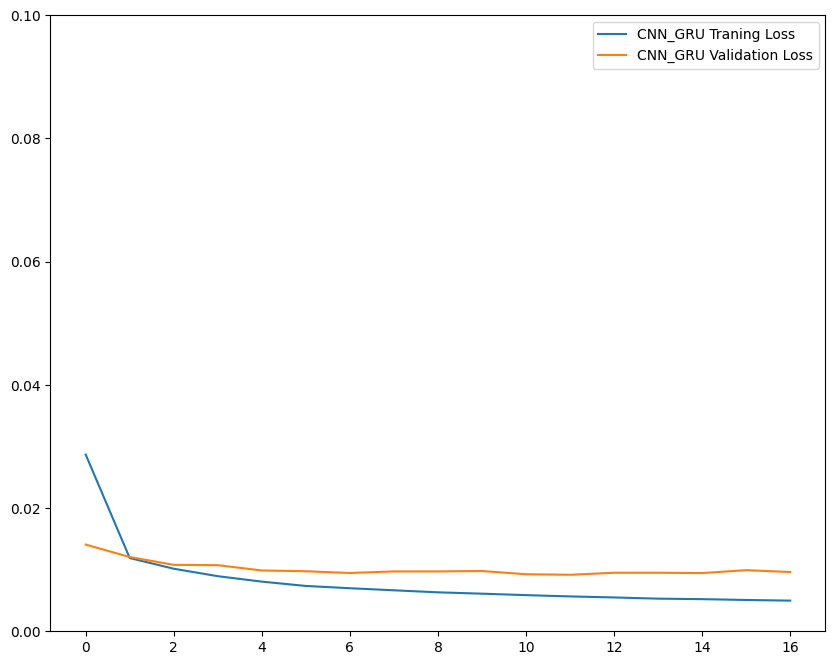

In [73]:
# Plotting Training History

plt.figure(figsize = [10,8])
plt.plot(loss,label = model_name + " Traning Loss")
plt.plot(val_loss, label = model_name + " Validation Loss")
plt.legend()
plt.ylim(0,0.1)
plt.savefig(model_path+'/'+model_name+'/model_training.png', dpi = 500)
plt.show()

'Trained Models\\CNN_GRU'

In [72]:
# Saving Trained Models
model_file_path = model_path +'/'+ model_name + '/' + model_name + '.h5'
#model.save(model_file_path)
model = keras.models.load_model(model_file_path)

## Prediction

Hoorray!!! Finally, it comes down to check predictive capabilities of our model and discuss get our sweet seven day ahead demand forecast. After getting the prediction from the trained models, these are compared with the actual values and plotted. We have also calculated the Mean squared error and Mean absolute percentage error as our performance metrics.

In [64]:
# Prediction on Train Data

real_train = mm_predict.inverse_transform(y_train)
real_val = mm_predict.inverse_transform(y_val)

predicted_train = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_train))).T)
predicted_val = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_val))).T)

229/229 [==============================] - 1s 6ms/step


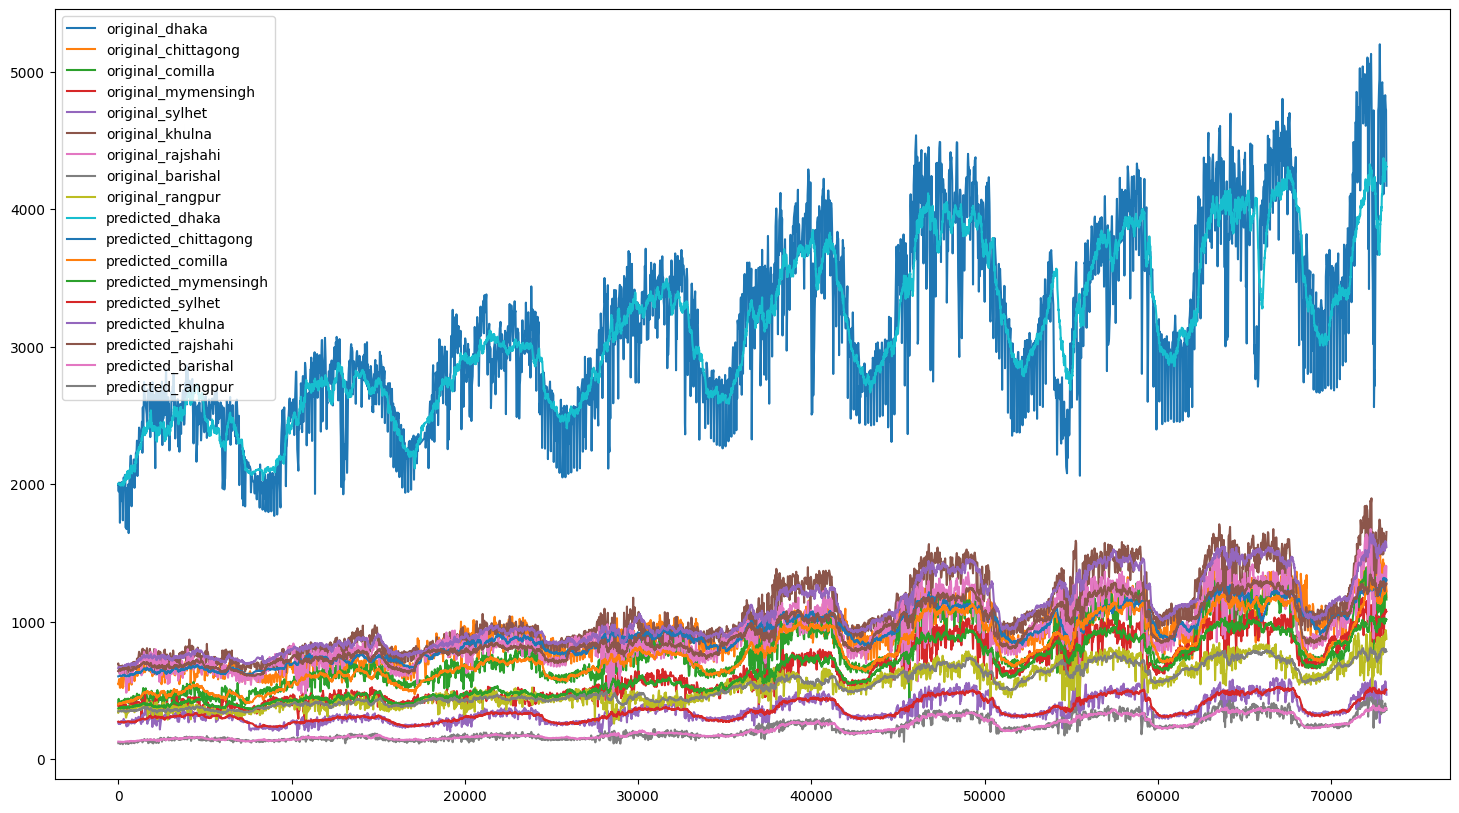

In [65]:
# Plotting the predictions

plt.figure(figsize = [18,10])
plt.plot(np.concatenate((real_train, real_val)), label = ['original_'+i for i in regions])
plt.plot(np.concatenate((predicted_train,predicted_val)), label = ['predicted_'+i for i in regions])
plt.legend()
plt.show()

In [61]:
# Prediction on Test Data
real = mm_predict.inverse_transform(y_test)
predicted = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_test))).T)

# finding the mape
for i in range(len(regions)):
  print('{} Region\t: MAPE {}, RMSE {}'.format(regions[i],mean_absolute_percentage_error(real[:,i], predicted[:,i]),
                                            np.sqrt(mean_squared_error(real[:,i], predicted[:,i]))))

6/6 [==============================] - 0s 5ms/step
dhaka Region	: MAPE 0.07005078706660219, RMSE 363.60510683797014
chittagong Region	: MAPE 0.05820586734442568, RMSE 92.67237430902513
comilla Region	: MAPE 0.06400603114468666, RMSE 100.5421426450814
mymensingh Region	: MAPE 0.05863720620042327, RMSE 74.16559594282418
sylhet Region	: MAPE 0.09080553846053777, RMSE 57.28430539662906
khulna Region	: MAPE 0.059568275509551946, RMSE 115.10620483607914
rajshahi Region	: MAPE 0.05337400143816222, RMSE 90.6558612174575
barishal Region	: MAPE 0.07874655888748966, RMSE 35.51970901993798
rangpur Region	: MAPE 0.07849625449923339, RMSE 72.01779504615338


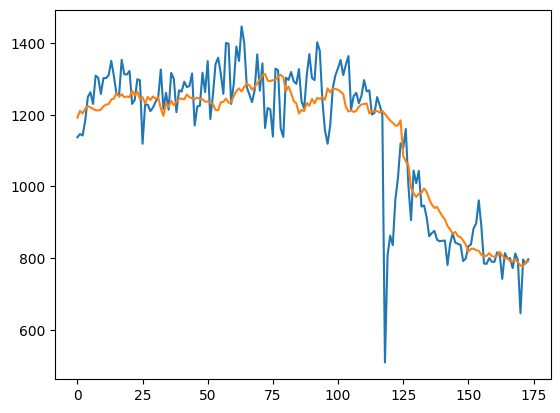

In [69]:
# Plotting the Prediction on Test Data

plt.plot(real[:,2])
plt.plot(predicted[:,2])

In [76]:
# Saving Predictions
real_df = pd.DataFrame(real, columns = regions)
predicted_df = pd.DataFrame(predicted, columns = regions)

real_df.to_excel(model_path + '/' + model_name + '/real_test_data.xlsx')
predicted_df.to_excel(model_path + '/' + model_name+'/predicted_test_data.xlsx')